In [1]:
import pandas as pd
import numpy as np
import os
import math

In [2]:
# Load the dataset

folder_path = './GDELT_Bitcoin_Sentiment/'

df_list = []
months = ['January', 'February', 'March', "April", 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

for month in months:
    print(f"Processing csv file for {month}")
    sentiment_file_path = os.path.join(folder_path, f"12 March GDELTS - {month}.csv") 
    df = pd.read_csv(sentiment_file_path)
    if 'DATE' in df.columns:
        df['DATE'] = pd.to_datetime(df['DATE'], format='%Y%m%d%H%M%S', errors='coerce')
        df_list.append(df)

df = pd.concat(df_list, ignore_index=True)
df = df.sort_values(by='DATE')

Processing csv file for January
Processing csv file for February
Processing csv file for March
Processing csv file for April
Processing csv file for May
Processing csv file for June
Processing csv file for July
Processing csv file for August
Processing csv file for September
Processing csv file for October
Processing csv file for November
Processing csv file for December


In [3]:
df

,DATE,SourceCommonName,DocumentIdentifier,OverallScore,PositiveScore,NegativeScore,PolarityScore,ActivenessScore
0,2024-01-01 00:00:00,barrons.com,https://www.barrons.com/market-data/bonds/ambm...,-3.947368,0.000000,3.947368,3.947368,19.956140
1,2024-01-01 00:00:00,cointelegraph.com,https://cointelegraph.com/news/cross-chain-pro...,-1.212121,1.515152,2.727273,4.242424,25.454545
2,2024-01-01 00:00:00,cointelegraph.com,https://cointelegraph.com/news/bitcoin-price-s...,-0.216606,2.166065,2.382671,4.548736,27.581227
3,2024-01-01 00:00:00,ettvamerica.com,https://www.ettvamerica.com/News/Article?i=252769,-5.185185,2.222222,7.407407,9.629630,24.296296
4,2024-01-01 00:15:00,forbes.com,https://www.forbes.com/sites/digital-assets/20...,0.892857,2.551020,1.658163,4.209184,22.704082
...,...,...,...,...,...,...,...,...
674208,2025-03-05 11:45:00,news.day.az,https://news.day.az/hitech/1734636.html,2.293578,4.587156,2.293578,6.880734,17.431193
674207,2025-03-05 11:45:00,variety1065.com,https://variety1065.com/html/79e12999791.html,2.989130,5.163043,2.173913,7.336957,24.728261
674222,2025-03-05 11:45:00,baotintuc.vn,https://baotintuc.vn/thoi-su/thu-truong-bo-tai...,2.564103,4.273504,1.709402,5.982906,26.923077
674214,2025-03-05 11:45:00,vietbao.vn,https://vietbao.vn/viet-nam-sap-co-san-giao-di...,0.694444,2.430556,1.736111,4.166667,26.388889


In [4]:
def compute_decayed_sentiment(df, lambda_decay=0.1, composite_func=None, date_column='DATE'):
    """
    Compute a decaying sentiment indicator from a dataframe of news events.
    
    Each event contributes a composite sentiment score that decays exponentially over time.
    The function returns two new columns:
      - 'DecayedSentiment': the cumulative decayed sentiment.
      - 'NormalizedDecayedSentiment': the decayed sentiment normalized by the decayed event weights.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing news events with at least a date column and sentiment score(s).
    lambda_decay : float, default 0.1
        Decay parameter controlling how quickly an event’s influence fades.
    composite_func : function, optional
        A function that takes a row (a pandas Series) and returns a composite sentiment score.
        If None, the function defaults to using the 'OverallScore' column.
    date_column : str, default 'DATE'
        Name of the column in df that contains the timestamp of each news event.
        
    Returns:
    --------
    pandas.DataFrame
        DataFrame with two additional columns:
         - 'DecayedSentiment'
         - 'NormalizedDecayedSentiment'
    """
    
    # If no composite function is provided, use the 'OverallScore' column.
    if composite_func is None:
        composite_func = lambda row: row['OverallScore']
    
    decayed_sentiments = []        # To store the cumulative sentiment S(t)
    normalized_sentiments = []     # To store the normalized sentiment score
    
    # Initialize cumulative sentiment and weight.
    S = 0.0      # Cumulative decayed sentiment
    W = 0.0      # Cumulative decayed weight (each event counts as 1 when it arrives)
    last_time = None
    
    # Iterate through each news event.
    for _, row in df.iterrows():
        current_time = row[date_column]
        # Compute the composite sentiment for the current event.
        s = composite_func(row)
        
        if last_time is None:
            # For the first event, initialize S and weight.
            S = s
            W = 1.0
        else:
            # Compute time difference (in seconds) from the last event.
            delta_t = (current_time - last_time).total_seconds()
            decay_factor = np.exp(-lambda_decay * delta_t)
            
            # Decay the previous cumulative sentiment and weight.
            S = S * decay_factor + s
            W = W * decay_factor + 1.0
        
        # Compute the normalized sentiment as a weighted average.
        normalized = S / W if W != 0 else S
        
        decayed_sentiments.append(S)
        normalized_sentiments.append(normalized)
        last_time = current_time  # Update the last event time.
    
    # Add the new computed columns to the dataframe.
    df['DecayedSentiment'] = decayed_sentiments
    df['NormalizedDecayedSentiment'] = normalized_sentiments
    
    return df


In [16]:
df['ActivenessScore'].min()

0.0

In [5]:
custom_composite = lambda row: row['OverallScore'] * (1 / np.log1p(row['ActivenessScore'] + 1))

# Compute the decayed sentiment (you can use custom_composite or leave it as None to use OverallScore).
result_df = compute_decayed_sentiment(df, lambda_decay=0.1, composite_func=custom_composite) #

df['DecayedSentiment'] = 100 * np.tanh(df['DecayedSentiment'] / 100)
df['NormalizedDecayedSentiment'] = 100 * np.tanh(df['NormalizedDecayedSentiment'] / 100)

# Display the results.
result_df[['DATE', 'OverallScore', 'DecayedSentiment', 'NormalizedDecayedSentiment']]

,DATE,OverallScore,DecayedSentiment,NormalizedDecayedSentiment
0,2024-01-01 00:00:00,-3.947368,-1.277790,-1.277790
1,2024-01-01 00:00:00,-1.212121,-1.643632,-0.821871
2,2024-01-01 00:00:00,-0.216606,-1.707563,-0.569237
3,2024-01-01 00:00:00,-5.185185,-3.292500,-0.823404
4,2024-01-01 00:15:00,0.892857,0.278411,0.278411
...,...,...,...,...
674208,2025-03-05 11:45:00,2.293578,-0.173527,-0.013348
674207,2025-03-05 11:45:00,2.989130,0.736193,0.052586
674222,2025-03-05 11:45:00,2.564103,1.498168,0.099885
674214,2025-03-05 11:45:00,0.694444,1.705659,0.106614


In [7]:
smooth_score_path = os.path.join(folder_path, "GDELTS_smooth_score.csv")
result_df.to_csv(smooth_score_path)

## plotty

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os

folder_path = '../data/GDELT_Bitcoin_Sentiment/'

# File paths
file1 = os.path.join(folder_path, "GDELTS_smooth_score.csv_part1.csv")
file2 = os.path.join(folder_path,"GDELTS_smooth_score.csv_part2.csv")

# Read CSV files
df1 = pd.read_csv(file1)
df2 = pd.read_csv(file2)


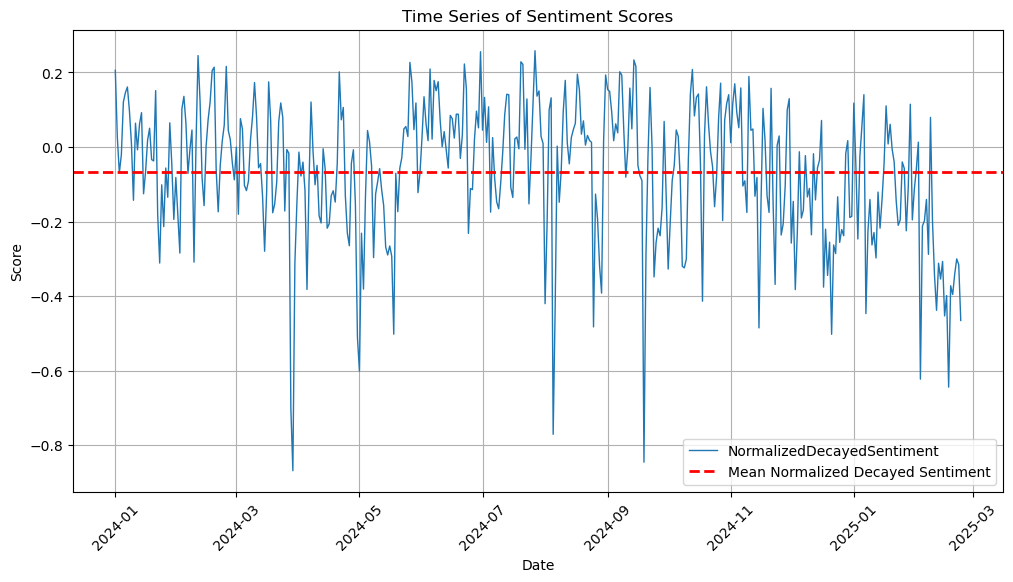

In [2]:
# Merge the two datasets
df = pd.concat([df1, df2])

# Select only specific columns
df = df[['DATE', 'OverallScore', 'DecayedSentiment', 'NormalizedDecayedSentiment']]

# Convert DATE column to datetime format
df['DATE'] = pd.to_datetime(df['DATE'])

# Ensure numeric columns are actually numeric
numeric_cols = ['OverallScore', 'DecayedSentiment', 'NormalizedDecayedSentiment']
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')

# Sort by date to ensure correct time series plotting
df = df.sort_values(by='DATE')

start_date = df['DATE'].min()
end_date = start_date + pd.Timedelta(weeks=60)
df_filtered = df[(df['DATE'] >= start_date) & (df['DATE'] < end_date)]

# Aggregate by day: Compute the daily mean for each sentiment score
df_daily = df_filtered.resample('D', on='DATE').mean().reset_index()

# Calculate the mean of 'NormalizedDecayedSentiment' for the first x weeks
mean_normalized_sentiment = df_daily['NormalizedDecayedSentiment'].mean()

# Plot the time series with 3 lines
plt.figure(figsize=(12, 6))
plt.plot(df_daily['DATE'], df_daily['NormalizedDecayedSentiment'], label='NormalizedDecayedSentiment', linewidth=1)
plt.axhline(y=mean_normalized_sentiment, color='red', linestyle='--', linewidth=2, label="Mean Normalized Decayed Sentiment")

# Formatting the plot
plt.xlabel("Date")
plt.ylabel("Score")
plt.title("Time Series of Sentiment Scores")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

# Show the plot
plt.show()


## Using Ethan's Script for score smoothing

In [4]:
df = df.rename(columns={'DATE': 'created_at'})

C:\Users\Justin\AppData\Local\Temp\ipykernel_21292\3699629246.py:4: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time = df['created_at'].min().floor('H')
C:\Users\Justin\AppData\Local\Temp\ipykernel_21292\3699629246.py:5: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  end_time = df['created_at'].max().ceil('H')
C:\Users\Justin\AppData\Local\Temp\ipykernel_21292\3699629246.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_index = pd.date_range(start=start_time, end=end_time, freq='H')


                     smoothed_sentiment
2024-01-01 00:00:00          -10.561281
2024-01-01 01:00:00           24.403801
2024-01-01 02:00:00           81.390333
2024-01-01 03:00:00          149.256078
2024-01-01 04:00:00          142.824226


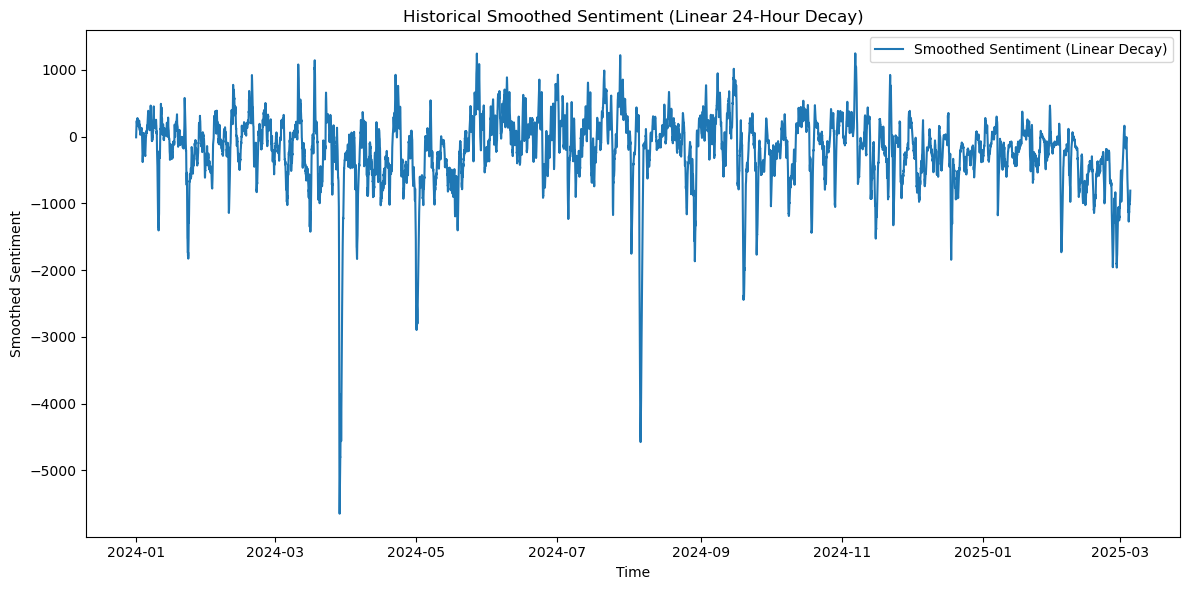

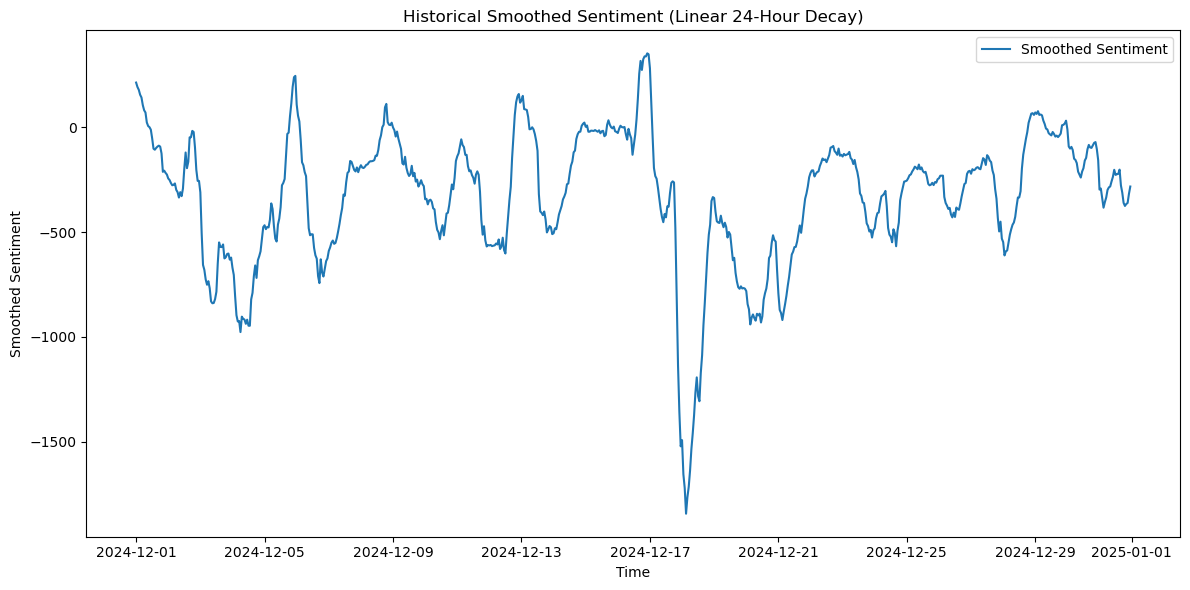

In [5]:
df['created_at'] = pd.to_datetime(df['created_at'])

# Define the start and end time for the analysis (rounded to the nearest hour)
start_time = df['created_at'].min().floor('H')
end_time = df['created_at'].max().ceil('H')

# Create an hourly date range
hourly_index = pd.date_range(start=start_time, end=end_time, freq='H')

def compute_smoothed_sentiment_linear(t):
    """
    Compute the smoothed sentiment at time t as the weighted sum of sentiment scores
    in the past 24 hours. Each news event decays linearly: its weight is 
    1 - (time difference in hours)/24.
    """
    # Define the 24-hour window for events affecting time t
    window_start = t - pd.Timedelta(hours=24)
    
    # Filter news events that occurred in the last 24 hours (excluding events after t)
    df_window = df[(df['created_at'] > window_start) & (df['created_at'] <= t)]
    
    if df_window.empty:
        return 0.0  # No news, no sentiment effect.
    
    # Calculate the time difference (in hours) between t and each news event
    time_diffs = (t - df_window['created_at']).dt.total_seconds() / 3600.0
    # Linear decay: weight = 1 - (difference/24)
    weights = 1 - (time_diffs / 24)
    weights = weights.clip(lower=0)  # Ensure no negative weights
    
    # Compute the weighted sentiment sum
    weighted_sentiment = (df_window['OverallScore'] * weights).sum()
    return weighted_sentiment

# Apply the function to each timestamp in the hourly index
smoothed_sentiments = [compute_smoothed_sentiment_linear(t) for t in hourly_index]

# Create a DataFrame with the results
df_sentiment = pd.DataFrame({'smoothed_sentiment': smoothed_sentiments}, index=hourly_index)

# Display the first few rows
print(df_sentiment.head())

# Optionally, plot the smoothed sentiment time series 
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.plot(df_sentiment.index, df_sentiment['smoothed_sentiment'], label='Smoothed Sentiment (Linear Decay)')
plt.xlabel('Time')
plt.ylabel('Smoothed Sentiment')
plt.title('Historical Smoothed Sentiment (Linear 24-Hour Decay)')
plt.legend()
plt.tight_layout()
plt.show()

#plot a section of the data from  2024-11 to 2024-12
plt.figure(figsize=(12,6))
plt.plot(df_sentiment.loc['2024-12':'2024-12'].index, df_sentiment.loc['2024-12':'2024-12']['smoothed_sentiment'], label='Smoothed Sentiment')
plt.xlabel('Time')
plt.ylabel('Smoothed Sentiment')
plt.title('Historical Smoothed Sentiment (Linear 24-Hour Decay)')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
from scipy.stats import weibull_min
import matplotlib.pyplot as plt


# Parameters for the Weibull distribution
k = 2.0       # shape parameter (k > 1 gives a peak)
lam = 6.0     # scale parameter in hours (peak attention around ~4.24 hours)
# Determine the mode (peak) of the Weibull PDF and compute its maximum value
x_mode = lam * ((k - 1) / k) ** (1 / k)
max_weight = weibull_min.pdf(x_mode, k, scale=lam)

def weight_function(x):
    """Compute the weight for elapsed time x (in hours) using the Weibull PDF normalized to 1."""
    if x < 0:
        return 0.0
    return weibull_min.pdf(x, k, scale=lam) / max_weight

# Create an hourly date range for the smoothed sentiment time series
hourly_index = pd.date_range(start=start_time, end=end_time, freq='H')

def compute_smoothed_sentiment_weibull(t):
    """
    Compute the smoothed sentiment at time t by summing the weighted sentiment scores
    from news events in the last 48 hours.
    """
    # Consider news events from the past 48 hours
    window_start = t - pd.Timedelta(hours=48)
    df_window = df[(df['created_at'] > window_start) & (df['created_at'] <= t)]
    if df_window.empty:
        return 0.0
    # Compute elapsed time in hours from each news event to time t
    time_diffs = (t - df_window['created_at']).dt.total_seconds() / 3600.0
    # Calculate weights for each news event using the Weibull function
    weights = time_diffs.apply(weight_function)
    # Compute the weighted sum of sentiment scores
    weighted_sentiment = (df_window['OverallScore'] * weights).sum()
    return weighted_sentiment

# Compute the smoothed sentiment for each hour in the time series
smoothed_sentiments = [compute_smoothed_sentiment_weibull(t) for t in hourly_index]
df_sentiment['smoothed_sentiment_weibull'] = smoothed_sentiments

# Display the first few rows
print(df_sentiment.head())

# Plot the smoothed sentiment over time
plt.figure(figsize=(12,6))
plt.plot(df_sentiment.index, df_sentiment['smoothed_sentiment_weibull'], label='Smoothed Sentiment (Weibull-based Decay)')
plt.xlabel('Time')
plt.ylabel('Smoothed Sentiment')
plt.title('Historical Smoothed Sentiment (Weibull-based Decay)')
plt.legend()
plt.tight_layout()
plt.show()

C:\Users\Justin\AppData\Local\Temp\ipykernel_21292\742560217.py:19: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_index = pd.date_range(start=start_time, end=end_time, freq='H')


In [ ]:
df_sentiment

In [ ]:
df_sentiment.info()

In [ ]:
# Add the weibull and linear sentiment to GDELT Data

df['datetime'] = pd.to_datetime(df['datetime'])
df = df.set_index('datetime')
df = df.join(df_sentiment)
# df = df.dropna()
print(df.head())
